# DEIMOS blue template

In [11]:
%matplotlib notebook

In [89]:
# imports
import numpy as np
from scipy.interpolate import interp1d
from pkg_resources import resource_filename

import os
import glob

from matplotlib import pyplot as plt

from pypeit import wavecalib
from pypeit.core.wavecal import wvutils
from pypeit.core.wavecal import templates

# Load one

In [3]:
wv_file = 'DEIMOS_blue/MasterWaveCalib_A_1_02_useS0106.fits'

In [4]:
wvcalib = wavecalib.WaveCalib.from_file(wv_file)

[INFO]    :: datamodel.py 1397 from_file() - Loading WaveCalib from DEIMOS_blue/MasterWaveCalib_A_1_02_useS0106.fits


In [8]:
wvcalib

<WaveCalib:  items={'wv_fits': True, 'wv_fit2d': False, 'arc_spectra': True, 'nslits': True, 'spat_ids': True, 'PYP_SPEC': True, 'strpar': True}>

## Parse

In [9]:
wvcalib.spat_ids

array([ 106,  291,  455,  568,  681,  808,  928, 1037, 1170, 1359, 1573,
       1697, 1819, 1961])

In [16]:
spec = wvcalib.arc_spectra[:,0]

In [24]:
npix = spec.size
wave = wvcalib.wv_fits[0].pypeitfit.eval(np.arange(npix)/(npix-1))

## Plot

<IPython.core.display.Javascript object>


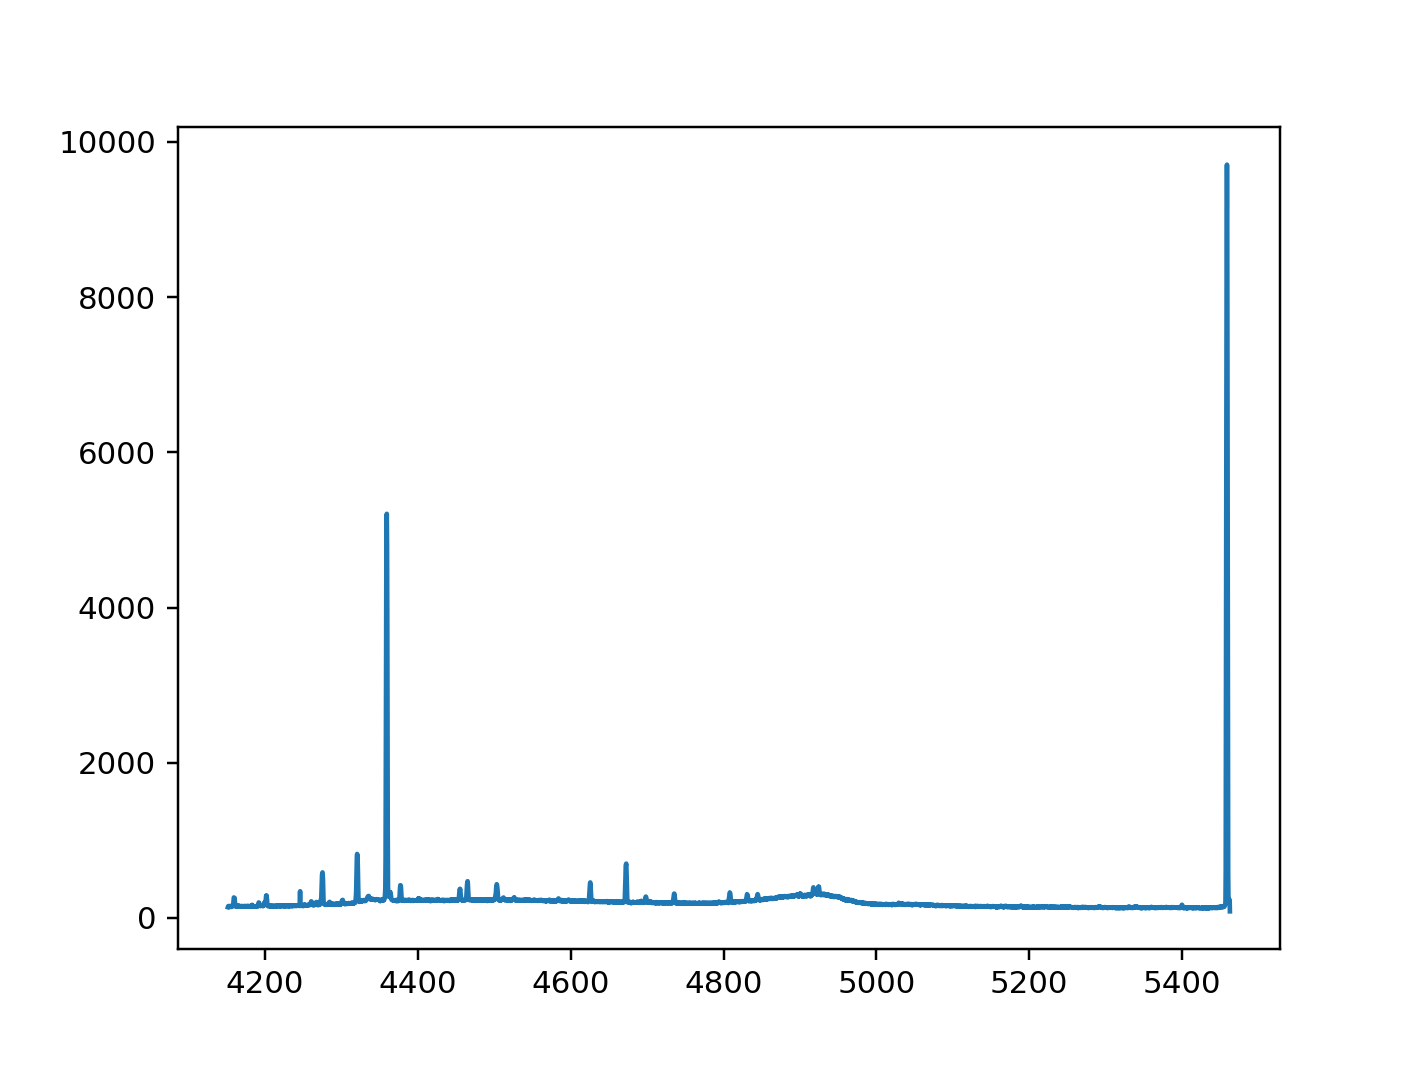

In [25]:
plt.clf()
ax = plt.gca()
ax.plot(wave, spec)
plt.show()

# Load em all up

In [27]:
files = glob.glob('DEIMOS_blue/Mas*')
files.sort()

In [28]:
wvcalibs = [wavecalib.WaveCalib.from_file(ifile) for ifile in files]

[INFO]    :: datamodel.py 1397 from_file() - Loading WaveCalib from DEIMOS_blue/MasterWaveCalib_A_1_02_useS0106.fits
[INFO]    :: datamodel.py 1397 from_file() - Loading WaveCalib from DEIMOS_blue/MasterWaveCalib_A_1_02_useS0291.fits
[INFO]    :: datamodel.py 1397 from_file() - Loading WaveCalib from DEIMOS_blue/MasterWaveCalib_A_1_06_useS0106.fits
[INFO]    :: datamodel.py 1397 from_file() - Loading WaveCalib from DEIMOS_blue/MasterWaveCalib_A_1_06_useS0287.fits


# Generate wave, spec arrays

In [31]:
snumb = [int(ifile[-9:-5]) for ifile in files]
snumb

[106, 291, 106, 287]

In [61]:
specs = []
waves = []
specs_sub = []
wvfits_idx = []
for kk, wvcalib in enumerate(wvcalibs):
    idx = np.where(wvcalib.spat_ids == snumb[kk])[0][0]
    wvfits_idx.append(idx)
    #print(idx)
    # Spectra
    specs.append(wvcalib.arc_spectra[:,idx])
    # Continuum
    _, _, _, _, spec_cont_sub = wvutils.arc_lines_from_spec(specs[-1])
    specs_sub.append(spec_cont_sub)
    # Wavelengths
    npix = specs[-1].size
    wave = wvcalib.wv_fits[idx].pypeitfit.eval(np.arange(npix)/(npix-1))
    waves.append(wave)
#
specs = np.stack(specs)
waves = np.stack(waves)
conti_specs = np.stack(specs_sub)

In [39]:
specs.shape, waves.shape

((4, 4096), (4, 4096))

# One plot

## Raw

<IPython.core.display.Javascript object>


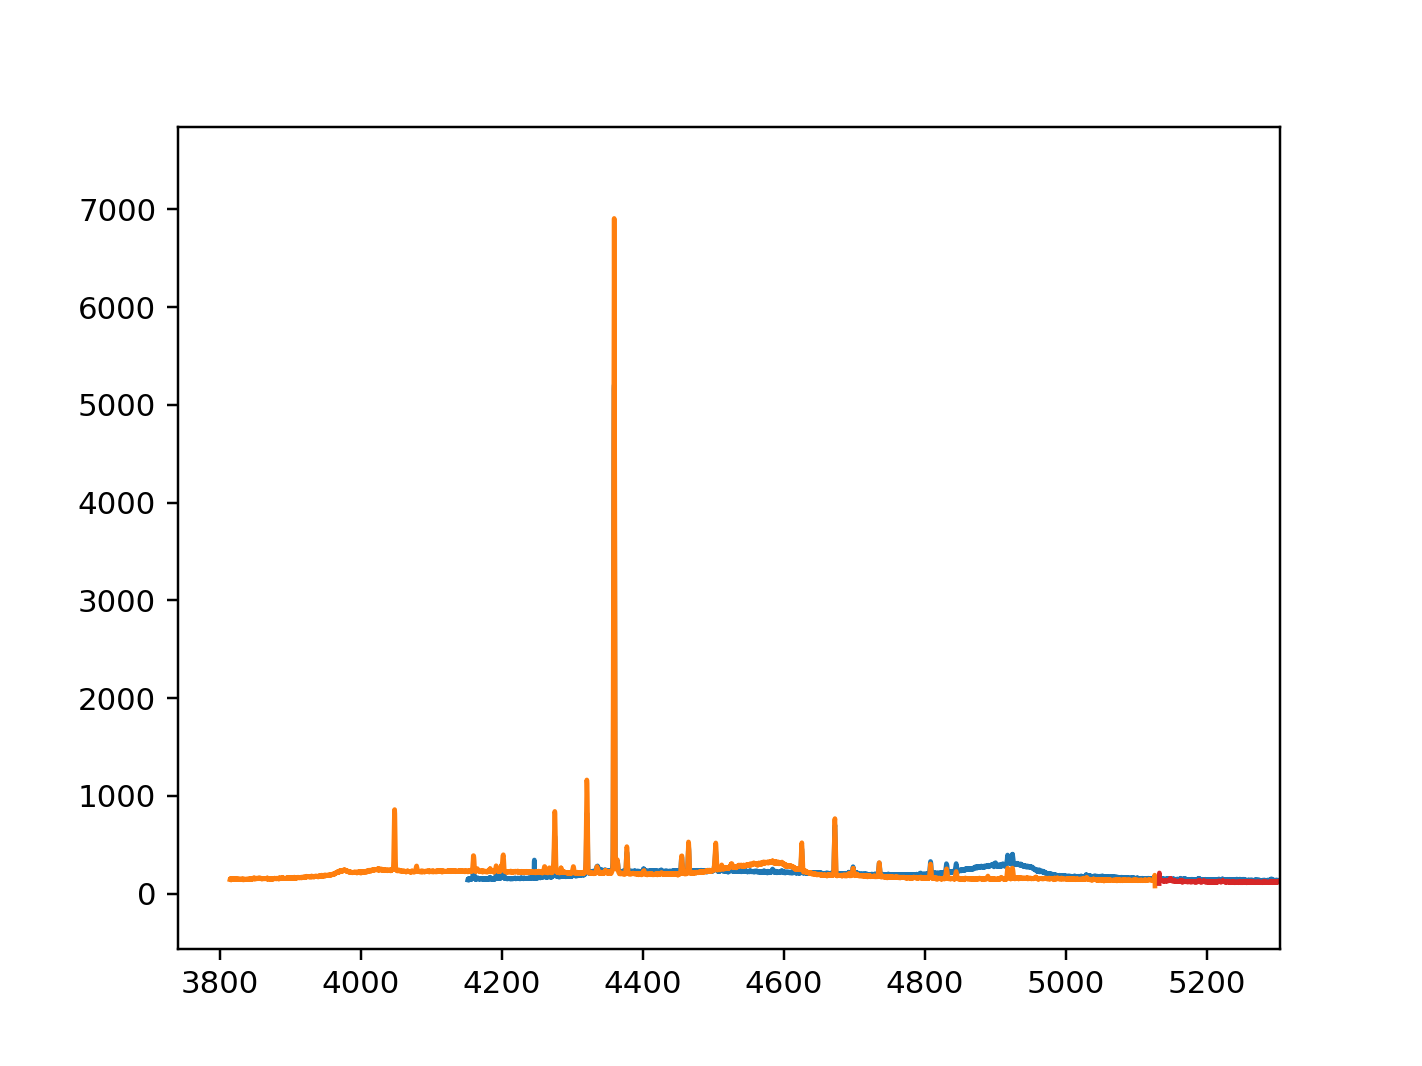

In [44]:
plt.clf()
ax = plt.gca()
for wave, spec in zip(waves, specs):
    ax.plot(wave, spec)
plt.show()

## Continuum subtracted

<IPython.core.display.Javascript object>


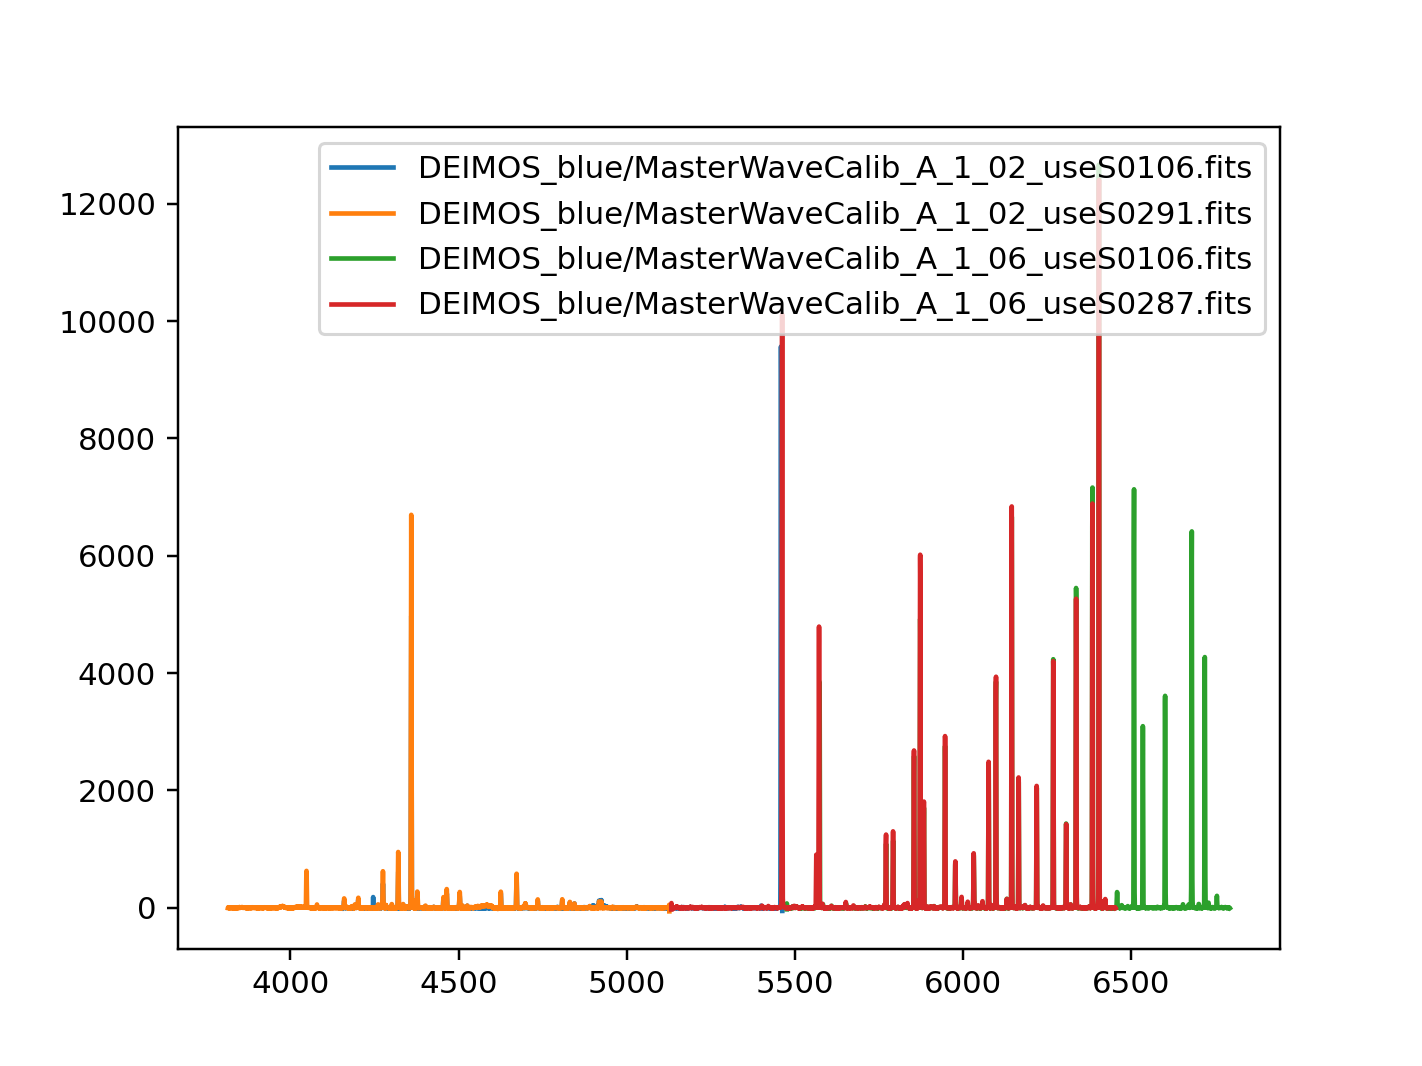

In [72]:
plt.clf()
ax = plt.gca()
for wave, spec, ifile in zip(waves, conti_specs, files):
    ax.plot(wave, spec, label=ifile)
plt.legend()
plt.show()

In [48]:
dwv = waves[0] - np.roll(waves[0],1)
dwv

array([-1.31109360e+03,  3.12570596e-01,  3.12574890e-01, ...,
        3.20807024e-01,  3.20801106e-01,  3.20795181e-01])

In [49]:
dv = dwv / waves[0]
dv

array([-3.15812805e-01,  7.52855209e-05,  7.52808877e-05, ...,
        5.87349777e-05,  5.87304448e-05,  5.87259112e-05])

# Set snippets

In [52]:
files

['DEIMOS_blue/MasterWaveCalib_A_1_02_useS0106.fits',
 'DEIMOS_blue/MasterWaveCalib_A_1_02_useS0291.fits',
 'DEIMOS_blue/MasterWaveCalib_A_1_06_useS0106.fits',
 'DEIMOS_blue/MasterWaveCalib_A_1_06_useS0287.fits']

In [53]:
snippets = [ 
    ['MasterWaveCalib_A_1_02_useS0291.fits', [3800., 4493.]],
    ['MasterWaveCalib_A_1_02_useS0106.fits', [4493., 4870.]],
    ['MasterWaveCalib_A_1_02_useS0291.fits', [4870., 5100.]],
    ['MasterWaveCalib_A_1_02_useS0106.fits', [5100., 5260.]],
    ['MasterWaveCalib_A_1_06_useS0287.fits', [5260., 5810.]],
    ['MasterWaveCalib_A_1_06_useS0106.fits', [5810., 6800.]],
]

# Shift by pixel in fit

In [66]:
template_wave = None
tempalte_spec = None
base_files = np.array([os.path.basename(ifile) for ifile in files])
for snippet in snippets:
    #import pdb; pdb.set_trace()
    idx = np.where(base_files == snippet[0])[0][0]
    #
    if template_wave is None:
        gd_wv = (waves[idx] > snippet[1][0]) & (waves[idx] <= snippet[1][1])
        template_wave = waves[idx][gd_wv].tolist()
        template_spec = conti_specs[idx][gd_wv].tolist()
    else:
        # Find pixel closet to end
        ipix = np.argmin(np.abs(template_wave[-1] - waves[idx]))
        # Difference between the two spectra at this pixel
        dwv_specs = waves[idx][ipix] - template_wave[-1]
        # Delta wv per pix
        dwv_snipp = waves[idx] - np.roll(waves[idx],1)
        dwv_snipp[0] = dwv_snipp[1]
        # Delta pix -- approximate but should be pretty good
        dpix = dwv_specs / dwv_snipp[ipix]
        # Calcualte new wavelengths
        npix = specs[idx].size
        new_wave = wvcalibs[idx].wv_fits[wvfits_idx[idx]].pypeitfit.eval((-dpix + np.arange(npix))/(npix-1))
        # Range
        iend = np.argmin(np.abs(new_wave-snippet[1][1]))
        # Interpolate
        f = interp1d(waves[idx], conti_specs[idx])
        new_spec = f(new_wave[ipix+1:iend])
        # Append
        template_wave += new_wave[ipix+1:iend].tolist()
        template_spec += new_spec.tolist()
#        import pdb; pdb.set_trace()

In [75]:
snippets[0]

['MasterWaveCalib_A_1_02_useS0291.fits', [3800.0, 4493.0]]

In [83]:
# Checking snippet boundary
template_wave[2100:2200]

[4477.723054808428,
 4478.045375894612,
 4478.367700254939,
 4478.690027887302,
 4479.012358789595,
 4479.334692959719,
 4479.657030395577,
 4479.9793710950735,
 4480.301715056118,
 4480.624062276625,
 4480.94641275451,
 4481.268766487691,
 4481.591123474095,
 4481.913483711644,
 4482.235847198271,
 4482.558213931907,
 4482.880583910491,
 4483.202957131961,
 4483.525333594261,
 4483.8477132953385,
 4484.170096233142,
 4484.492482405628,
 4484.81487181075,
 4485.137264446472,
 4485.459660310756,
 4485.7820594015675,
 4486.10446171688,
 4486.426867254667,
 4486.749276012904,
 4487.071687989573,
 4487.394103182658,
 4487.716521590149,
 4488.038943210032,
 4488.361368040305,
 4488.683796078964,
 4489.006227324013,
 4489.328661773452,
 4489.651099425293,
 4489.973540277546,
 4490.295984328224,
 4490.618431575348,
 4490.940882016937,
 4491.26333565102,
 4491.585792475619,
 4491.908252488771,
 4492.230715688508,
 4492.553182072871,
 4492.8756516399,
 4493.193412029134,
 4493.511175977336,
 44

# Plot!

<IPython.core.display.Javascript object>


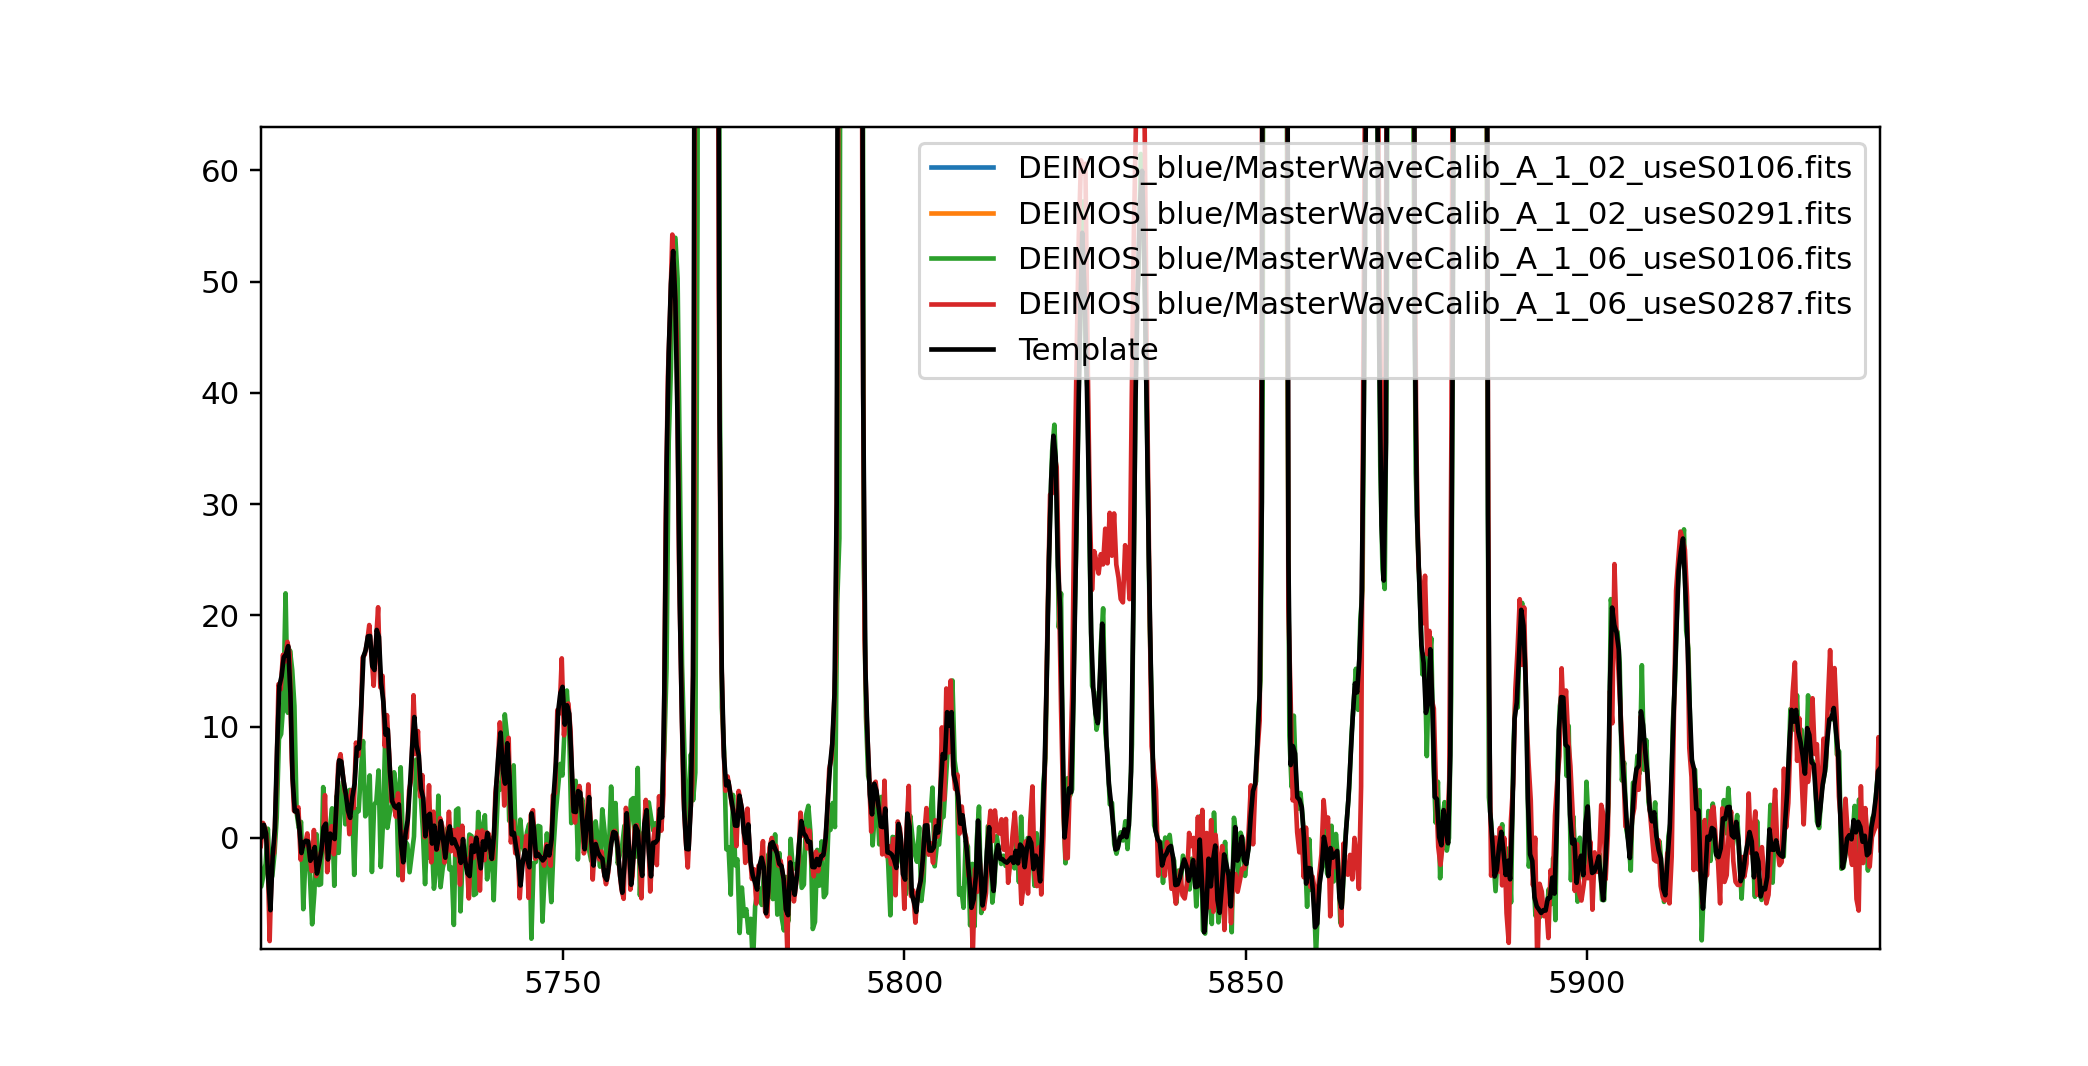

In [73]:
plt.clf()
ax = plt.gca()
for wave, spec, ifile in zip(waves, conti_specs, files):
    ax.plot(wave, spec, label=ifile)
# Template
ax.plot(template_wave, template_spec, color='k', label='Template')
plt.legend()
plt.show()

# Write new template

In [90]:
binspec = 1
outroot='keck_deimos_1200B.fits'
outpath = resource_filename('pypeit', 'data/arc_lines/reid_arxiv')

In [91]:
templates.write_template(template_wave, template_spec, binspec, outpath, outroot)

Wrote: /home/xavier/Projects/PypeIt/pypeit/data/arc_lines/reid_arxiv/keck_deimos_1200B.fits
